In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import torch, torch.nn as nn
import torchvision

from copy import copy
from IPython import display
from IPython.display import clear_output
from PIL import Image
from skimage import color, transform
from sklearn.metrics import roc_auc_score
from time import time, sleep
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

In [2]:
device = 'cpu'

In [3]:
fmnist_train_set = torchvision.datasets.FashionMNIST("./data_fmnist", download=True,
                                                     transform=transforms.Compose([transforms.ToTensor()]))
fmnist_test_set = torchvision.datasets.FashionMNIST("./data_fmnist", download=True, train=False,
                                                    transform=transforms.Compose([transforms.ToTensor()]))
fmnist_train_data = DataLoader(fmnist_train_set, batch_size=32)
fmnist_test_data = DataLoader(fmnist_test_set, batch_size=32)

In [4]:
mnist_train_set = torchvision.datasets.MNIST("./data_mnist", download=True,
                                             transform=transforms.Compose([transforms.ToTensor()]))
mnist_test_set = torchvision.datasets.MNIST("./data_mnist", download=True, train=False,
                                            transform=transforms.Compose([transforms.ToTensor()]))
mnist_train_data = DataLoader(mnist_train_set, batch_size=32)
mnist_test_data = DataLoader(mnist_test_set, batch_size=32)

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.block_1_conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.block_1_relu = nn.ReLU()
        self.block_1_max_pool = nn.MaxPool2d(kernel_size=2)

        self.block_2_conv = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)
        self.block_2_relu = nn.ReLU()
        self.block_2_max_pool = nn.MaxPool2d(kernel_size=2)
        self.block_2_batch_norm = nn.BatchNorm2d(num_features=16)

        self.block_3_flatten = nn.Flatten()
        self.block_3_linear = nn.Linear(in_features=400, out_features=100)
        self.block_3_relu = nn.ReLU()

        self.block_4_linear = nn.Linear(in_features=100, out_features=10)
        self.block_4_log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.block_1_conv(x)
        x = self.block_1_relu(x)
        x = self.block_1_max_pool(x)

        x = self.block_2_conv(x)
        x = self.block_2_relu(x)
        x = self.block_2_max_pool(x)
        x = self.block_2_batch_norm(x)

        x = self.block_3_flatten(x)
        x = self.block_3_linear(x)
        x = self.block_3_relu(x)

        x = self.block_4_linear(x)
        x = self.block_4_log_softmax(x)
        return x

In [6]:
def validate(teacher, student, data):
    teacher.eval()
    student.eval()
    total_img = 0
    loss = 0
    for images, _ in tqdm(data):
        with torch.no_grad():
            # Transfering images and labels to GPU if available
            images = images.to(device)
            images = images.view(-1, 1, 28, 28)
            total_img += len(images)
            # Forward pass
            with torch.no_grad():
                teacher_pred = teacher(images)
            student_pred = student(images)
            loss += forward_kl(teacher_pred, student_pred).item()
    return round(loss / total_img, 5)

In [7]:
def plot_results(train_log, val_log, test_log):
    clear_output(wait=True)
    print("Epoch", len(train_log))
    print("Train loss:\t", train_log[-1])
    print("Val loss:\t", val_log[-1])
    print("Test loss:\t", test_log[-1])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(train_log, label='train loss', c='b')
    ax1.plot(val_log, label='val loss', c='r')
    ax1.grid()
    ax1.legend(loc='best')

    ax2.plot(test_log, label='test_loss', c='g')
    ax2.legend(loc='best')
    ax2.grid()
    plt.show()

In [8]:
def cross_entroy_with_logits(teacher_pred, student_pred):
    return -torch.sum(torch.exp(teacher_pred) * student_pred, dim=1).mean()

In [9]:
def forward_kl(teacher_pred, student_pred):
    return torch.sum(torch.exp(teacher_pred) * (teacher_pred - student_pred))

In [10]:
def reverse_kl(teacher_pred, student_pred):
    return torch.sum(torch.exp(student_pred) * (student_pred - teacher_pred))

In [11]:
def symmetrized_kl(teacher_pred, student_pred):
    return forward_kl(student_pred, teacher_pred) + revrse_kl(student_pred, teacher_pred)

In [12]:
def train(teacher, student, optimizer, train_log, val_log, test_log, num_epochs=30, batch_size=32):
    for epoch in range(num_epochs):
        teacher.train()
        student.train()
        for images, _ in tqdm(mnist_train_data):
            # Transfering images and labels to GPU if available
            images = images.view(-1, 1, 28, 28).to(device)
            # Forward pass
            with torch.no_grad():
                teacher_pred = teacher(images)
            student_pred = student(images)
            loss = forward_kl(student_pred, teacher_pred)
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_log.append(validate(teacher, student, mnist_train_data))
        val_log.append(validate(teacher, student, mnist_test_data))
        test_log.append(validate(teacher, student, fmnist_train_data))
        plot_results(train_log, val_log, test_log)

In [13]:
train_log = []
val_log = []
test_log = []

In [14]:
teacher = ConvNet().to(device)
student = ConvNet().to(device)

In [15]:
optimizer = torch.optim.Adam(student.parameters(), lr=0.0001)

Epoch 50
Train loss:	 0.00183
Val loss:	 0.00208
Test loss:	 0.00541


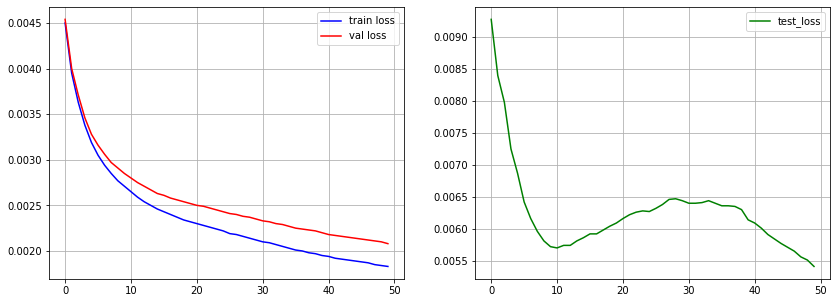

CPU times: user 5h 13min 22s, sys: 23min 53s, total: 5h 37min 16s
Wall time: 1h 35min 44s


In [16]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [17]:
def get_prediction_errors(teacher, student, data):
    teacher.eval()
    student.eval()
    loss = []
    for images, _ in tqdm(data):
        with torch.no_grad():
            # Transfering images and labels to GPU if available
            images = images.to(device)
            images = images.view(-1, 1, 28, 28)
            # Forward pass
            teacher_pred = teacher(images)
            student_pred = student(images)
            loss.append(reverse_kl(teacher_pred, student_pred).item())
    return loss

In [18]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))

In [19]:
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8843110448611111

Epoch 100
Train loss:	 0.00137
Val loss:	 0.0016
Test loss:	 0.00412


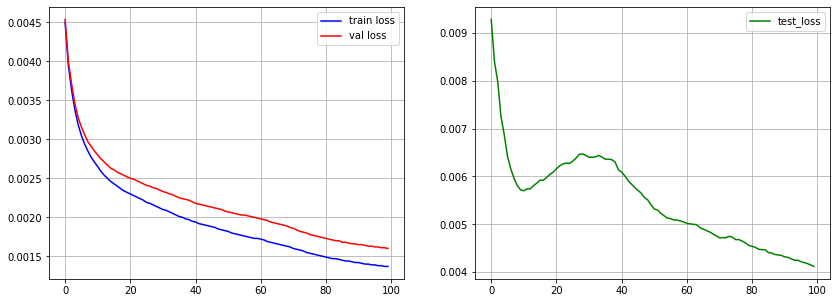

CPU times: user 5h 12min 27s, sys: 30min 4s, total: 5h 42min 32s
Wall time: 1h 31min 47s


In [20]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [21]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8839121152777777

Epoch 150
Train loss:	 0.00114
Val loss:	 0.00135
Test loss:	 0.00307


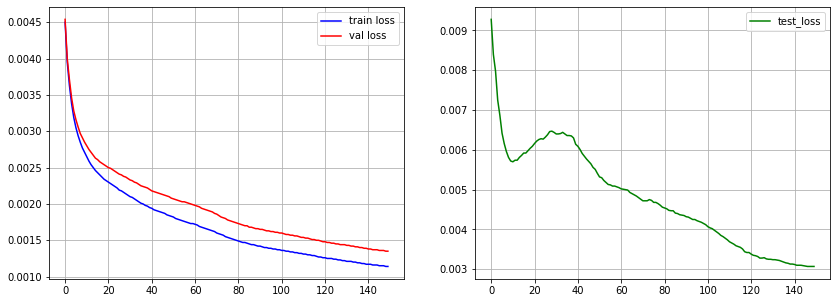

CPU times: user 5h 18min 20s, sys: 25min 26s, total: 5h 43min 46s
Wall time: 1h 33min 38s


In [22]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [23]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8621657979166667

Epoch 200
Train loss:	 0.00094
Val loss:	 0.00111
Test loss:	 0.00242


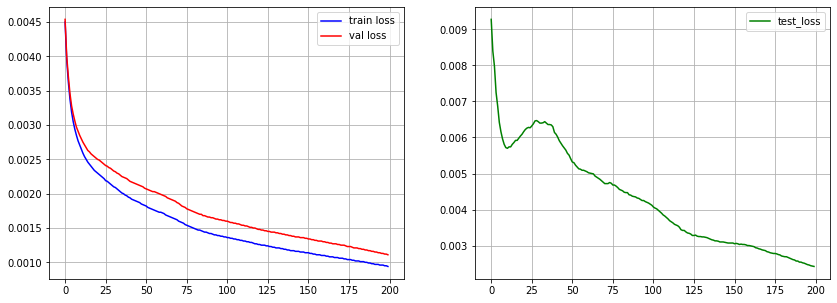

CPU times: user 4h 42min 50s, sys: 22min 51s, total: 5h 5min 41s
Wall time: 1h 40min 34s


In [24]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [25]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8542319705555554

Epoch 250
Train loss:	 0.00081
Val loss:	 0.00095
Test loss:	 0.00196


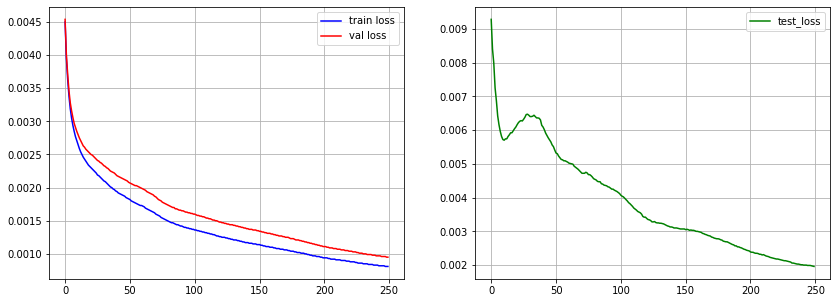

CPU times: user 3h 52min 25s, sys: 23min 2s, total: 4h 15min 27s
Wall time: 1h 43min 23s


In [26]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [27]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8479258063888888

Epoch 300
Train loss:	 0.00071
Val loss:	 0.00084
Test loss:	 0.00168


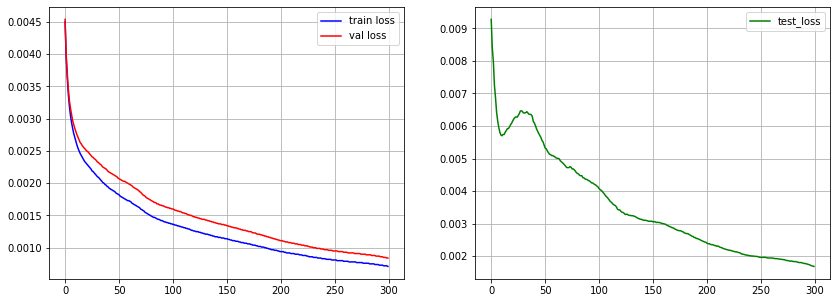

CPU times: user 3h 46min 53s, sys: 22min 2s, total: 4h 8min 56s
Wall time: 1h 48min 12s


In [28]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [29]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.8316728916666667

Epoch 350
Train loss:	 0.00061
Val loss:	 0.00072
Test loss:	 0.00126


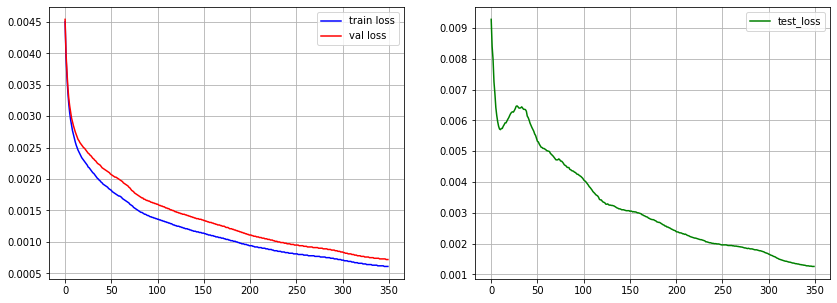

CPU times: user 3h 41min 36s, sys: 21min 47s, total: 4h 3min 23s
Wall time: 1h 41min 2s


In [30]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [31]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.7967009870833333

Epoch 400
Train loss:	 0.00056
Val loss:	 0.00067
Test loss:	 0.00112


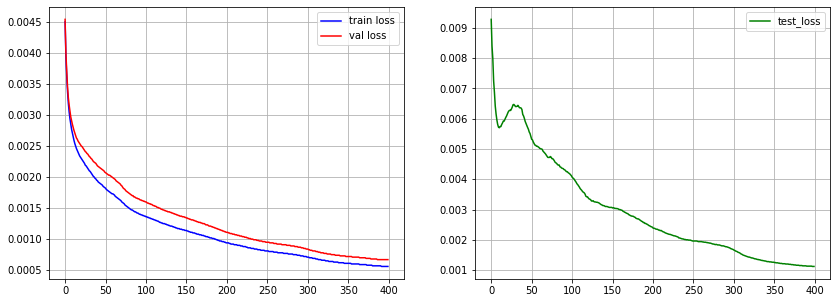

CPU times: user 3h 40min 53s, sys: 21min 34s, total: 4h 2min 28s
Wall time: 1h 40min 49s


In [32]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [33]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.7880438086111111

Epoch 450
Train loss:	 0.00054
Val loss:	 0.00064
Test loss:	 0.00107


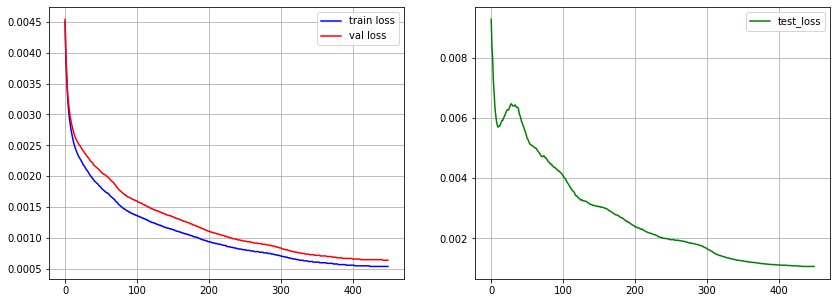

CPU times: user 3h 52min 15s, sys: 23min 2s, total: 4h 15min 17s
Wall time: 1h 41min 29s


In [34]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [35]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.7882500354166666

Epoch 500
Train loss:	 0.00053
Val loss:	 0.00063
Test loss:	 0.00105


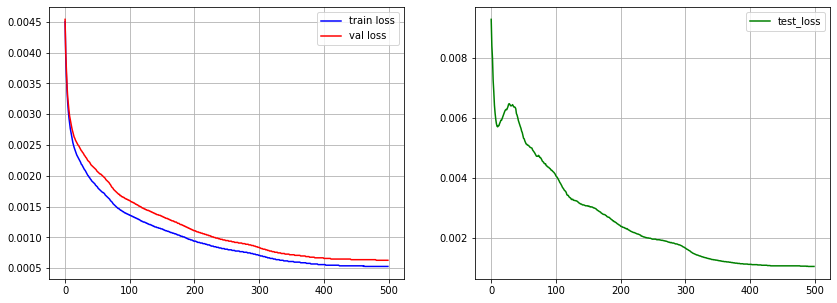

CPU times: user 3h 50min 24s, sys: 22min 35s, total: 4h 12min 59s
Wall time: 1h 43min 17s


In [36]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [37]:
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

0.7889159124999999

Epoch 550
Train loss:	 0.00052
Val loss:	 0.00062
Test loss:	 0.00102


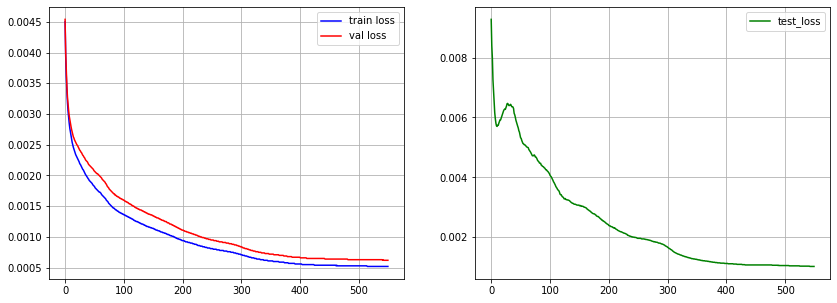


CPU times: user 3h 57min 38s, sys: 23min 36s, total: 4h 21min 14s
Wall time: 1h 43min 26s


0.7894870272222222

In [38]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

Epoch 600
Train loss:	 0.00052
Val loss:	 0.00062
Test loss:	 0.00103


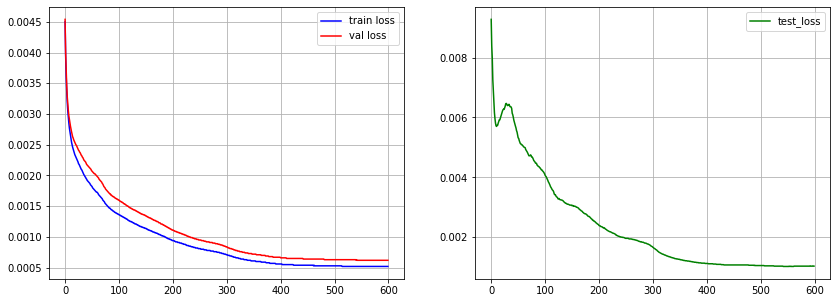


CPU times: user 3h 55min 36s, sys: 23min 13s, total: 4h 18min 50s
Wall time: 1h 42min 49s


0.7991366669444444

In [39]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)

Epoch 700
Train loss:	 0.00051
Val loss:	 0.00061
Test loss:	 0.00104


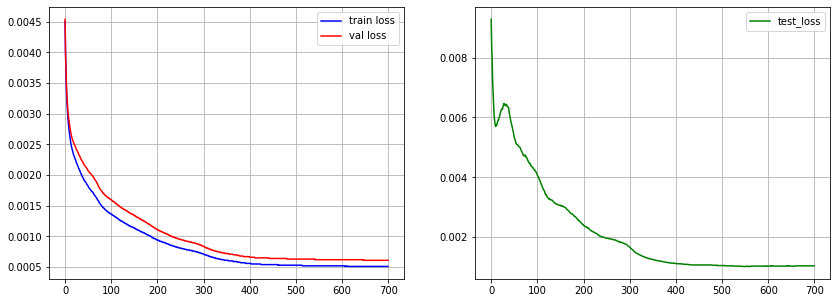


CPU times: user 8h 15min 16s, sys: 45min 15s, total: 9h 32s
Wall time: 3h 28min 55s


0.8083946826388889

In [40]:
%%time
train(teacher, student, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=100)
fmnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(teacher, student, DataLoader(mnist_train_set, batch_size=1))
y_true = [0] * len(mnist_prediction_errors) + [1] * len(fmnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors
roc_auc_score(y_true, y_pred)